In [7]:
import argparse
import configparser
import pandas as pd
import boto3
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
import pymc3 as pm
import theano.tensor as tt
import arviz as az
from scipy import stats as sts
import warnings
from model import DataModel
from model import BayesModel
warnings.simplefilter(action="ignore", category=FutureWarning)

In [2]:
parser = argparse.ArgumentParser()
parser.add_argument('--dummy', nargs='?', default='None')
parser.add_argument('--last-n-days', nargs='?', default='30', type=int)
parser.add_argument('--num-samples', nargs='*', default=1000, type=int)
parser.add_argument('--num-burnin', nargs='*', default=5000, type=int)
parser.add_argument("-c", "--config", dest='config_file', default='config.ini', type=str)
args = parser.parse_args(args=['--dummy'])

config = configparser.ConfigParser()
config.read(args.config_file)
args.s3_bucket = config.get('default', 's3_bucket')
args.s3_prefix = config.get('default', 's3_prefix')

In [ ]:
# check if any schema change
df_sample = Data.get_one_sample(args.s3_bucket, args.s3_prefix)
df_sample.columns

In [ ]:
# check na%
Data.check_na(df_sample, 0.3)

In [5]:
data = Data(args.s3_bucket, args.s3_prefix, args.last_n_days)
data.get_raw_generator()
data.preprocessing()

In [ ]:
data.df_processed

In [ ]:
suspects = [(9.65, 'Down'), (11.8, 'Down'), (21.39, 'Up') , (26.25, 'Up')] # chainage, direction
for chainage, direction in suspects:
    data.scatter_plot_chainage_hue(chainage, direction)
    
# detailed examine_features = {
#     'gauge': ['gauge'],
#     'bolaccy': ['bolaccy'],
#     'acc': ['acc1', 'acc2', 'acc3', 'acc4'], 
#     'lat_jerk': ['bod1_lat_jerk', 'bod2_lat_jerk'],
#     'lon_jerk': ['bod1_lon_jerk', 'bod2_lon_jerk'],
# }

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nu, sigma_2, sigma_1, sigma_sensor, beta_2, beta_1, mu_2, mu_1, switch]


Sampling 4 chains for 5_000 tune and 1_000 draw iterations (20_000 + 4_000 draws total) took 40 seconds.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There were 138 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.4625047797207863, but should be close to 0.8. Try to increase the number of tuning steps.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


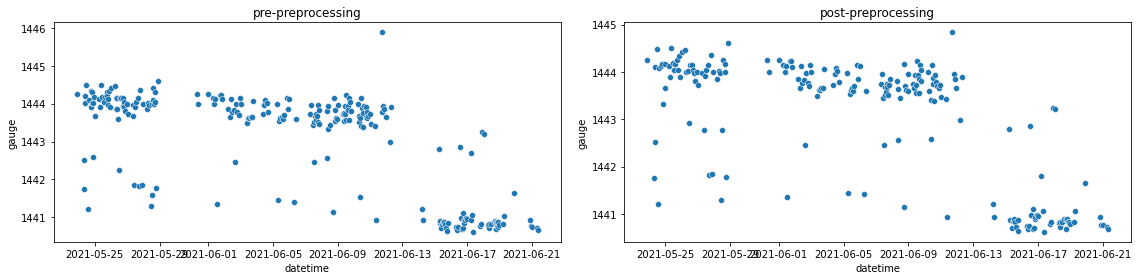

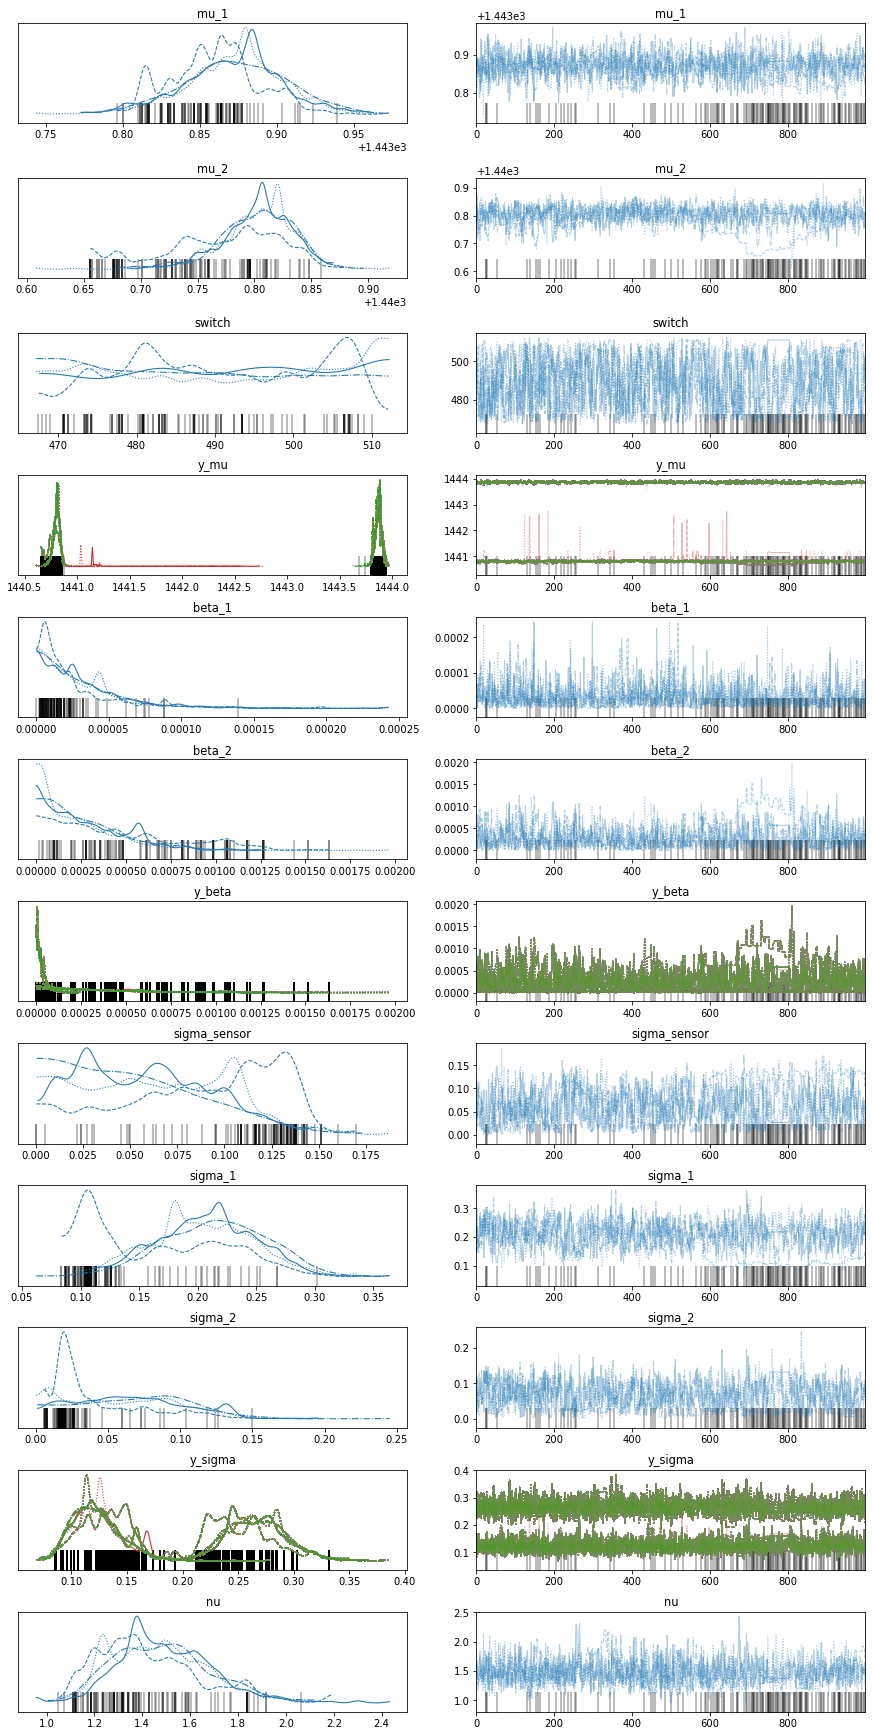

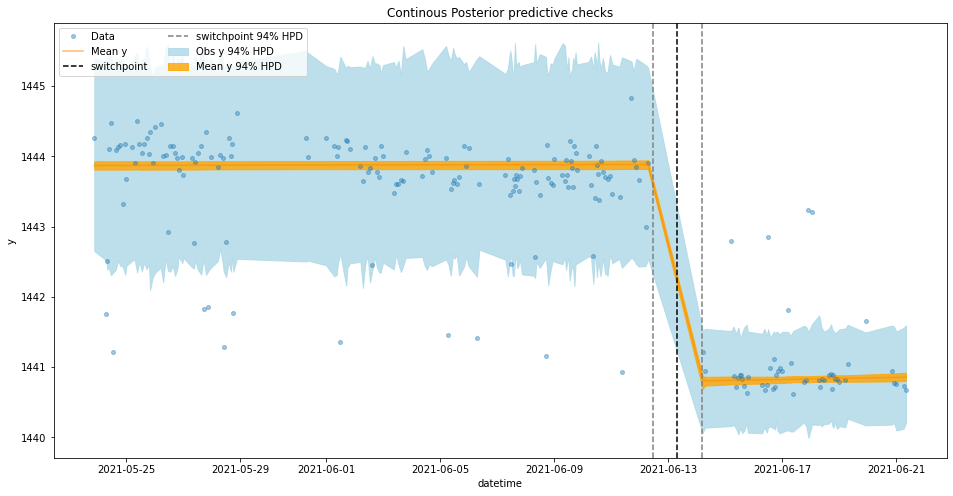

In [113]:
suspect = (9.65, 'Down')
target = 'gauge'
df = data.sub_df(*suspect, target)

sp_model = SwitchPointModel.from_df(df=df, target=target, num_samples=args.num_samples, num_burnin=args.num_burnin)
sp_model.define_model() 
sp_model.fit()
sp_model.plot_trace()
sp_model.plot_posterior_predictive()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nu, sigma_, y_beta, y_mu]


Sampling 4 chains for 5_000 tune and 1_000 draw iterations (20_000 + 4_000 draws total) took 25 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


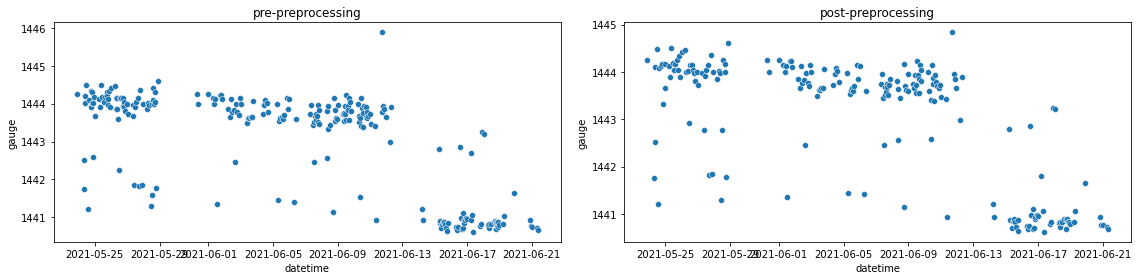

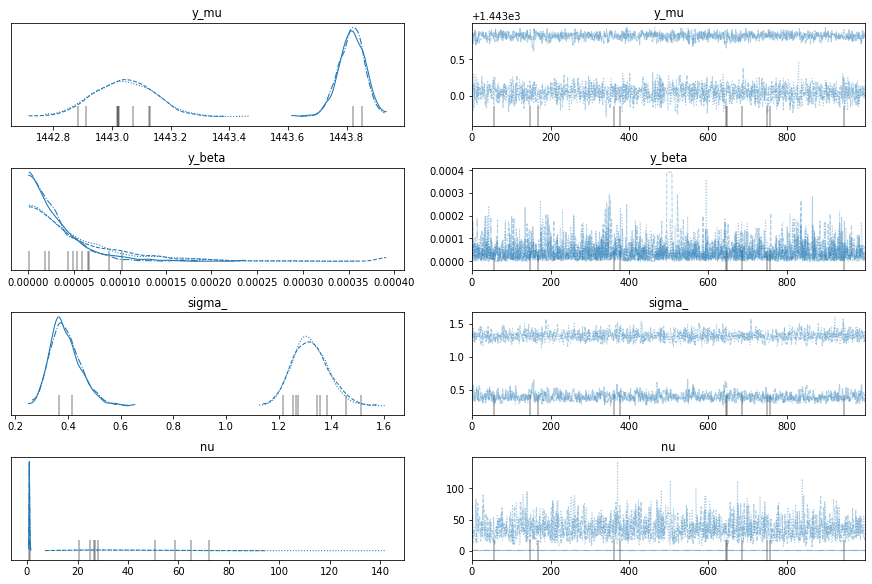

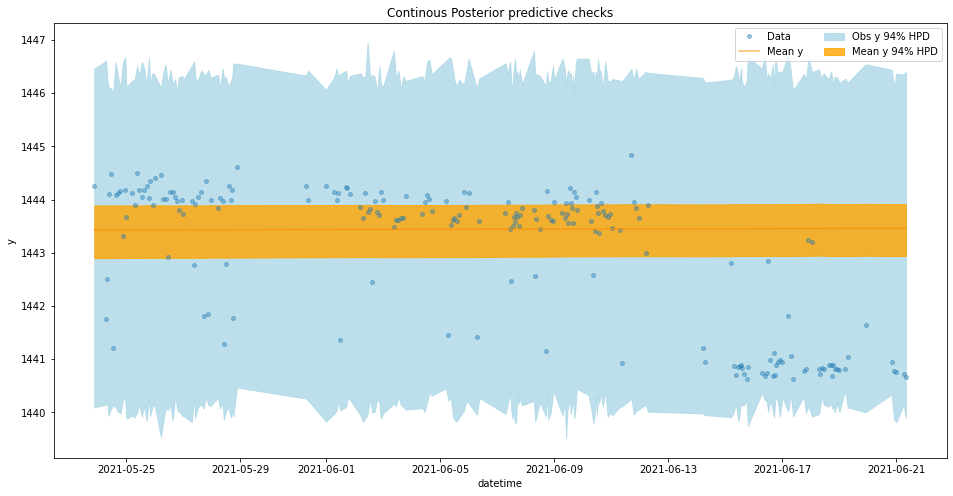

In [114]:
suspect = (9.65, 'Down')
target = 'gauge'
df = data.sub_df(*suspect, target)

baseline_model = BaseLineModel.from_df(df=df, target=target, num_samples=args.num_samples, num_burnin=args.num_burnin)
baseline_model.define_model() 
baseline_model.fit()
baseline_model.plot_trace()
baseline_model.plot_posterior_predictive()

# Model comparison to determine if the switchpoint is significant

In [232]:
def select_model(p=0.6):
    comparison = az.compare({"switchpoint": sp_model.trace, "baseline": baseline_model.trace})
    stats = ['rank', 'weight', 'loo', 'd_loo']
    comp = comparison[stats]
    
    chosen_model_idx = 0 if comp.iloc[0]['weight']>p else 1
    chosen_model = comp.index[chosen_model_idx]
    return chosen_model, comp

chosen_model, comp = select_model()
print(f'chosen model: {chosen_model}')
comp

C:\Users\benyp\anaconda3\envs\pm\lib\site-packages\arviz\stats\stats.py:145: UserWarning: The default method used to estimate the weights for each model,has changed from BB-pseudo-BMA to stacking
  warnings.warn(


chosen model: switchpoint


,rank,weight,loo,d_loo
switchpoint,0,0.954817,-135.019842,0.00000
baseline,1,0.045183,-380.160082,245.14024


In [236]:
def get_params():
    params = ['mu_1', 'mu_2', 'beta_1', 'beta_2', 'sigma_1', 'sigma_2', 'sigma_sensor']
    stats = ['mean']#, 'sd']
    summary = az.summary(sp_model.trace)
    summ = summary[stats].T[params]
    return summ

get_params()

,mu_1,mu_2,beta_1,beta_2,sigma_1,sigma_2,sigma_sensor
mean,1443.869,1440.795,0.0,0.0,0.197,0.059,0.066


# Gaussian Process

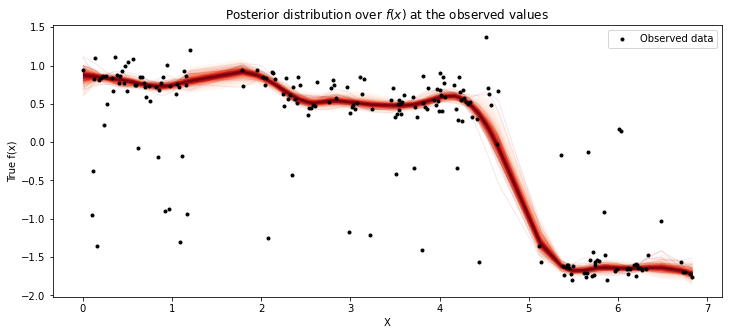

In [269]:
y=sp_model.y
y_std = y.std()
y_mean = y.mean()
y = (y-y_mean)/y_std
X=sp_model.t[:, None]/100

with pm.Model() as model:
    ℓ = pm.Gamma("ℓ", alpha=2, beta=1)
    η = pm.HalfCauchy("η", beta=1)

    cov = η ** 2 * pm.gp.cov.Matern52(1, ℓ)
    gp = pm.gp.Latent(cov_func=cov)

    f = gp.prior("f", X=X)

    σ = pm.HalfCauchy("σ", beta=5)
    ν = pm.Gamma("ν", alpha=2, beta=0.1)
    y_ = pm.StudentT("y", mu=f, lam=1.0 / σ, nu=ν, observed=y)

    trace = pm.sample(1000, chains=2, cores=1, return_inferencedata=True)

# plot the results
fig = plt.figure(figsize=(12, 5))
ax = fig.gca()

# plot the samples from the gp posterior with samples and shading
from pymc3.gp.util import plot_gp_dist

plot_gp_dist(ax, trace.posterior["f"][0, :, :], X)

# plot the data
ax.plot(X, y, "ok", ms=3, label="Observed data")

# axis labels and title
plt.xlabel("X")
plt.ylabel("True f(x)")
plt.title("Posterior distribution over $f(x)$ at the observed values")
plt.legend();